In [1]:
import sys
import os

import sqlite3
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import numpy as np

sys.path.insert(0, '../src') # add library code to path

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Processing Raw Data to Lightdump

In [2]:
from wikiparser import download_metadata_zips

zip_outdir = "../data/raw/zips"

download_metadata_zips(1, zip_outdir , False)

https://dumps.wikimedia.org/enwiki/20200101/enwiki-20200101-stub-meta-history1.xml.gz


In [3]:
zips = os.listdir(zip_outdir)
zips

['metadata-20200101-1.xml.gz', 'enwiki-20200101-0.7z', '.ipynb_checkpoints']

In [4]:
from wikiparser import gunzip_shutil

extract_outdir = "../data/raw/extracted"

for gzip_file in os.listdir(zip_outdir ):
    if gzip_file[-2:] == "gz":
        gunzip_shutil(zip_outdir + "/" + gzip_file, extract_outdir)
    

Extracted file already exists: ../data/raw/extracted/metadata-20200101-1.xml


In [7]:
from wikiparser import parse_metadata_to_lightdump

#parse enwiki to lightdump
file_to_parse = "../data/raw/extracted/metadata-20200101-1.xml"
lightdump_filename = "popularity_dump.txt"
temp_dir = "../data/temp"
articles = ["Aardvark", 'Blizzard_Entertainment', 'American_League_Championship_Series']

In [8]:
parse_metadata_to_lightdump(file_to_parse , lightdump_filename, temp_dir, articles)

Writing Aardvark 3198 revisions to popularity_dump.txt
Writing American_League_Championship_Series 810 revisions to popularity_dump.txt
Writing Blizzard_Entertainment 4122 revisions to popularity_dump.txt


# Visualize Lightdump Article Byte Size

Starting Lightdump Parse for: Anarchism
Finished Lightdump Parse => num revisions: 18885
Saving plot to "../data/out/Anarchism.png"


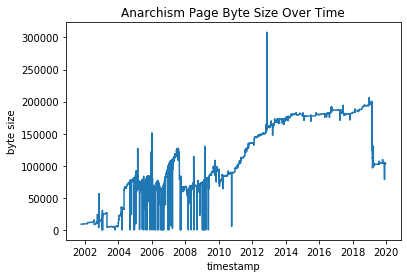

In [25]:
from engagement_score import create_wiki_graph

fig1 = create_wiki_graph("../data/temp/popularity_dump.txt", "Anarchism", "../data/out")

Starting Lightdump Parse for: Autism
Finished Lightdump Parse => num revisions: 10276
Saving plot to "../data/out/Autism.png"


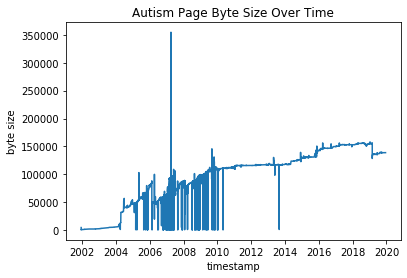

In [26]:
fig2 = create_wiki_graph("../data/temp/popularity_dump.txt", "Autism", "../data/out")

# Lightdump to DB Averaged by Month

In [27]:
from engagement_score import lightdump_to_db

lightdump_file = "../data/temp/popularity_dump.txt"
outfile = "../data/out/articles.db"
#lightdump_to_db(lightdump_file, outfile)


0: FINISHED LIGHTDUMP PARSE FOR:   AccessibleComputing		 NUM REVISIONS: 13
1: FINISHED LIGHTDUMP PARSE FOR:   Anarchism		 NUM REVISIONS: 18885
2: FINISHED LIGHTDUMP PARSE FOR:   AfghanistanHistory		 NUM REVISIONS: 6
3: FINISHED LIGHTDUMP PARSE FOR:   AfghanistanGeography		 NUM REVISIONS: 7
4: FINISHED LIGHTDUMP PARSE FOR:   AfghanistanPeople		 NUM REVISIONS: 8
5: FINISHED LIGHTDUMP PARSE FOR:   AfghanistanCommunications		 NUM REVISIONS: 5
6: FINISHED LIGHTDUMP PARSE FOR:   AfghanistanTransportations		 NUM REVISIONS: 9
7: FINISHED LIGHTDUMP PARSE FOR:   AfghanistanMilitary		 NUM REVISIONS: 6
8: FINISHED LIGHTDUMP PARSE FOR:   AfghanistanTransnationalIssues		 NUM REVISIONS: 5
9: FINISHED LIGHTDUMP PARSE FOR:   AssistiveTechnology		 NUM REVISIONS: 6
10: FINISHED LIGHTDUMP PARSE FOR:   AmoeboidTaxa		 NUM REVISIONS: 8
11: FINISHED LIGHTDUMP PARSE FOR:   Autism		 NUM REVISIONS: 10276
12: FINISHED LIGHTDUMP PARSE FOR:   AlbaniaHistory		 NUM REVISIONS: 6
13: FINISHED LIGHTDUMP PARSE FOR:   Alb

118: FINISHED LIGHTDUMP PARSE FOR:   Algae		 NUM REVISIONS: 4204
119: FINISHED LIGHTDUMP PARSE FOR:   Analysis_of_variance		 NUM REVISIONS: 1338
120: FINISHED LIGHTDUMP PARSE FOR:   ANOVA		 NUM REVISIONS: 4
121: FINISHED LIGHTDUMP PARSE FOR:   Appellate_procedure_in_the_United_States		 NUM REVISIONS: 516
122: FINISHED LIGHTDUMP PARSE FOR:   Answer_(law)		 NUM REVISIONS: 363
123: FINISHED LIGHTDUMP PARSE FOR:   Appellate_court		 NUM REVISIONS: 359
124: FINISHED LIGHTDUMP PARSE FOR:   Arithmetic_and_logic_unit		 NUM REVISIONS: 5
125: FINISHED LIGHTDUMP PARSE FOR:   Actress		 NUM REVISIONS: 15
126: FINISHED LIGHTDUMP PARSE FOR:   Arraignment		 NUM REVISIONS: 255
127: FINISHED LIGHTDUMP PARSE FOR:   America_the_Beautiful		 NUM REVISIONS: 1253
128: FINISHED LIGHTDUMP PARSE FOR:   Assistive_technology		 NUM REVISIONS: 1065
129: FINISHED LIGHTDUMP PARSE FOR:   Accessible_computing		 NUM REVISIONS: 12
130: FINISHED LIGHTDUMP PARSE FOR:   Abacus		 NUM REVISIONS: 3616
131: FINISHED LIGHTDUMP PAR

227: FINISHED LIGHTDUMP PARSE FOR:   Altaic_languages		 NUM REVISIONS: 1808
228: FINISHED LIGHTDUMP PARSE FOR:   Austrian_German		 NUM REVISIONS: 615
229: FINISHED LIGHTDUMP PARSE FOR:   Austria/Transnational_issues		 NUM REVISIONS: 7
230: FINISHED LIGHTDUMP PARSE FOR:   Talk:Acronym/Archive_3		 NUM REVISIONS: 194
231: FINISHED LIGHTDUMP PARSE FOR:   Anglican_Church		 NUM REVISIONS: 13
232: FINISHED LIGHTDUMP PARSE FOR:   Axiom_of_choice		 NUM REVISIONS: 1178
233: FINISHED LIGHTDUMP PARSE FOR:   Attila		 NUM REVISIONS: 5284
234: FINISHED LIGHTDUMP PARSE FOR:   Aegean_Sea		 NUM REVISIONS: 1223
235: FINISHED LIGHTDUMP PARSE FOR:   A_Clockwork_Orange_(novel)		 NUM REVISIONS: 3455
236: FINISHED LIGHTDUMP PARSE FOR:   Talk:A_Clockwork_Orange_(novel)		 NUM REVISIONS: 224
237: FINISHED LIGHTDUMP PARSE FOR:   Museum_of_Work		 NUM REVISIONS: 30
238: FINISHED LIGHTDUMP PARSE FOR:   Audi		 NUM REVISIONS: 4246
239: FINISHED LIGHTDUMP PARSE FOR:   Alfred_Nobel		 NUM REVISIONS: 3176
240: FINISHED LI

339: FINISHED LIGHTDUMP PARSE FOR:   Miss_Marple		 NUM REVISIONS: 1172
340: FINISHED LIGHTDUMP PARSE FOR:   April		 NUM REVISIONS: 2623
341: FINISHED LIGHTDUMP PARSE FOR:   August		 NUM REVISIONS: 2140
342: FINISHED LIGHTDUMP PARSE FOR:   Aaron		 NUM REVISIONS: 3371
343: FINISHED LIGHTDUMP PARSE FOR:   Achill_Island		 NUM REVISIONS: 892
344: FINISHED LIGHTDUMP PARSE FOR:   Allen_Ginsberg		 NUM REVISIONS: 3566
345: FINISHED LIGHTDUMP PARSE FOR:   Anatoly_Karpov		 NUM REVISIONS: 1120
346: FINISHED LIGHTDUMP PARSE FOR:   Aspect_ratio		 NUM REVISIONS: 261
347: FINISHED LIGHTDUMP PARSE FOR:   Auto_racing		 NUM REVISIONS: 3169
348: FINISHED LIGHTDUMP PARSE FOR:   Anarcho-capitalists		 NUM REVISIONS: 3
349: FINISHED LIGHTDUMP PARSE FOR:   Aristophanes		 NUM REVISIONS: 1673
350: FINISHED LIGHTDUMP PARSE FOR:   Albert_Schweitzer		 NUM REVISIONS: 2404
351: FINISHED LIGHTDUMP PARSE FOR:   Talk:Auteur		 NUM REVISIONS: 83
352: FINISHED LIGHTDUMP PARSE FOR:   Abscess		 NUM REVISIONS: 818
353: FINISH

452: FINISHED LIGHTDUMP PARSE FOR:   Applet		 NUM REVISIONS: 381
453: FINISHED LIGHTDUMP PARSE FOR:   Alternate_history		 NUM REVISIONS: 2806
454: FINISHED LIGHTDUMP PARSE FOR:   Atomic_orbitals		 NUM REVISIONS: 8
455: FINISHED LIGHTDUMP PARSE FOR:   Atomic_orbital		 NUM REVISIONS: 1572
456: FINISHED LIGHTDUMP PARSE FOR:   Alan_Turing		 NUM REVISIONS: 7940
457: FINISHED LIGHTDUMP PARSE FOR:   Area		 NUM REVISIONS: 2536
458: FINISHED LIGHTDUMP PARSE FOR:   Astronomical_unit		 NUM REVISIONS: 1792
459: FINISHED LIGHTDUMP PARSE FOR:   Artist		 NUM REVISIONS: 2620
460: FINISHED LIGHTDUMP PARSE FOR:   Actaeon		 NUM REVISIONS: 413
461: FINISHED LIGHTDUMP PARSE FOR:   Anglicanism		 NUM REVISIONS: 4356
462: FINISHED LIGHTDUMP PARSE FOR:   Athens		 NUM REVISIONS: 12357
463: FINISHED LIGHTDUMP PARSE FOR:   Anguilla		 NUM REVISIONS: 1745
464: FINISHED LIGHTDUMP PARSE FOR:   Anguilla/Transnational_issues		 NUM REVISIONS: 7
465: FINISHED LIGHTDUMP PARSE FOR:   Anguilla/Military		 NUM REVISIONS: 6
46

565: FINISHED LIGHTDUMP PARSE FOR:   Alligatoridae		 NUM REVISIONS: 403
566: FINISHED LIGHTDUMP PARSE FOR:   Alder		 NUM REVISIONS: 645
567: FINISHED LIGHTDUMP PARSE FOR:   Amos_Bronson_Alcott		 NUM REVISIONS: 569
568: FINISHED LIGHTDUMP PARSE FOR:   Arachnophobia		 NUM REVISIONS: 1575
569: FINISHED LIGHTDUMP PARSE FOR:   Alabaster		 NUM REVISIONS: 566
570: FINISHED LIGHTDUMP PARSE FOR:   Talk:Alan_Turing		 NUM REVISIONS: 1138
571: FINISHED LIGHTDUMP PARSE FOR:   ASIC_(disambiguation)		 NUM REVISIONS: 59
572: FINISHED LIGHTDUMP PARSE FOR:   Dasyproctidae		 NUM REVISIONS: 117
573: FINISHED LIGHTDUMP PARSE FOR:   Amazing_Grace		 NUM REVISIONS: 2727
574: FINISHED LIGHTDUMP PARSE FOR:   AOL		 NUM REVISIONS: 5284
575: FINISHED LIGHTDUMP PARSE FOR:   ADHD		 NUM REVISIONS: 27
576: FINISHED LIGHTDUMP PARSE FOR:   Talk:Anno_Domini		 NUM REVISIONS: 768
577: FINISHED LIGHTDUMP PARSE FOR:   AV		 NUM REVISIONS: 325
578: FINISHED LIGHTDUMP PARSE FOR:   Amino_group		 NUM REVISIONS: 42
579: FINISHED L

684: FINISHED LIGHTDUMP PARSE FOR:   Aimoin		 NUM REVISIONS: 56
685: FINISHED LIGHTDUMP PARSE FOR:   Akkadian_Empire		 NUM REVISIONS: 2424
686: FINISHED LIGHTDUMP PARSE FOR:   Ajax_the_Lesser		 NUM REVISIONS: 263
687: FINISHED LIGHTDUMP PARSE FOR:   Ajax_the_Great		 NUM REVISIONS: 1165
688: FINISHED LIGHTDUMP PARSE FOR:   Ajax		 NUM REVISIONS: 923
689: FINISHED LIGHTDUMP PARSE FOR:   Alaric_I		 NUM REVISIONS: 739
690: FINISHED LIGHTDUMP PARSE FOR:   Alaric_II		 NUM REVISIONS: 206
691: FINISHED LIGHTDUMP PARSE FOR:   Albategnius		 NUM REVISIONS: 13
692: FINISHED LIGHTDUMP PARSE FOR:   Albertus_Magnus		 NUM REVISIONS: 1247
693: FINISHED LIGHTDUMP PARSE FOR:   Alboin		 NUM REVISIONS: 631
694: FINISHED LIGHTDUMP PARSE FOR:   Afonso_de_Albuquerque		 NUM REVISIONS: 1447
695: FINISHED LIGHTDUMP PARSE FOR:   Alcaeus_of_Mytilene		 NUM REVISIONS: 330
696: FINISHED LIGHTDUMP PARSE FOR:   Alcamenes		 NUM REVISIONS: 76
697: FINISHED LIGHTDUMP PARSE FOR:   Alcmene		 NUM REVISIONS: 405
698: FINISHED 

800: FINISHED LIGHTDUMP PARSE FOR:   Alphonso_XII		 NUM REVISIONS: 2
801: FINISHED LIGHTDUMP PARSE FOR:   Alphonso_XIII		 NUM REVISIONS: 2
802: FINISHED LIGHTDUMP PARSE FOR:   Talk:Amaryllis		 NUM REVISIONS: 56
803: FINISHED LIGHTDUMP PARSE FOR:   Autpert_Ambrose		 NUM REVISIONS: 55
804: FINISHED LIGHTDUMP PARSE FOR:   Abu_Bakr		 NUM REVISIONS: 5334
805: FINISHED LIGHTDUMP PARSE FOR:   Ambrose_Traversari		 NUM REVISIONS: 127
806: FINISHED LIGHTDUMP PARSE FOR:   Ambrosians		 NUM REVISIONS: 52
807: FINISHED LIGHTDUMP PARSE FOR:   Ambrosiaster		 NUM REVISIONS: 87
808: FINISHED LIGHTDUMP PARSE FOR:   Ambrosius_Aurelianus		 NUM REVISIONS: 583
809: FINISHED LIGHTDUMP PARSE FOR:   Talk:Aleksandr_Solzhenitsyn		 NUM REVISIONS: 418
810: FINISHED LIGHTDUMP PARSE FOR:   Ammon		 NUM REVISIONS: 600
811: FINISHED LIGHTDUMP PARSE FOR:   Ammonius_Hermiae		 NUM REVISIONS: 123
812: FINISHED LIGHTDUMP PARSE FOR:   Ammonius_Saccas		 NUM REVISIONS: 247
813: FINISHED LIGHTDUMP PARSE FOR:   Book_of_Amos		 NUM

912: FINISHED LIGHTDUMP PARSE FOR:   Geography_of_Africa		 NUM REVISIONS: 804
913: FINISHED LIGHTDUMP PARSE FOR:   Africa/History		 NUM REVISIONS: 3
914: FINISHED LIGHTDUMP PARSE FOR:   Approval_voting		 NUM REVISIONS: 994
915: FINISHED LIGHTDUMP PARSE FOR:   Aromatic_compound		 NUM REVISIONS: 38
916: FINISHED LIGHTDUMP PARSE FOR:   Arizona_State_University		 NUM REVISIONS: 5092
917: FINISHED LIGHTDUMP PARSE FOR:   Talk:Apple_(fruit)		 NUM REVISIONS: 18
918: FINISHED LIGHTDUMP PARSE FOR:   Talk:Aikido		 NUM REVISIONS: 1370
919: FINISHED LIGHTDUMP PARSE FOR:   Astoria,_Oregon		 NUM REVISIONS: 1054
920: FINISHED LIGHTDUMP PARSE FOR:   Alarums_and_Excursions		 NUM REVISIONS: 95
921: FINISHED LIGHTDUMP PARSE FOR:   Talk:America_(disambiguation)/Archive_1		 NUM REVISIONS: 394
922: FINISHED LIGHTDUMP PARSE FOR:   Talk:The_Ashes		 NUM REVISIONS: 295
923: FINISHED LIGHTDUMP PARSE FOR:   Alfred_Jarry		 NUM REVISIONS: 480
924: FINISHED LIGHTDUMP PARSE FOR:   Amalric		 NUM REVISIONS: 78
925: FINI

1023: FINISHED LIGHTDUMP PARSE FOR:   Addictive		 NUM REVISIONS: 7
1024: FINISHED LIGHTDUMP PARSE FOR:   Auschwitz_concentration_camp		 NUM REVISIONS: 5707
1025: FINISHED LIGHTDUMP PARSE FOR:   Archery		 NUM REVISIONS: 3795
1026: FINISHED LIGHTDUMP PARSE FOR:   Al_Qaeda		 NUM REVISIONS: 7
1027: FINISHED LIGHTDUMP PARSE FOR:   Alvar_Aalto		 NUM REVISIONS: 1029
1028: FINISHED LIGHTDUMP PARSE FOR:   Talk:Addiction		 NUM REVISIONS: 368
1029: FINISHED LIGHTDUMP PARSE FOR:   Atomic_semantics		 NUM REVISIONS: 73
1030: FINISHED LIGHTDUMP PARSE FOR:   Antarctic_Circumpolar_Current		 NUM REVISIONS: 312
1031: FINISHED LIGHTDUMP PARSE FOR:   A._J._Ayer		 NUM REVISIONS: 689
1032: FINISHED LIGHTDUMP PARSE FOR:   André_Weil		 NUM REVISIONS: 496
1033: FINISHED LIGHTDUMP PARSE FOR:   Achaeans_(Homer)		 NUM REVISIONS: 392
1034: FINISHED LIGHTDUMP PARSE FOR:   Atle_Selberg		 NUM REVISIONS: 273
1035: FINISHED LIGHTDUMP PARSE FOR:   Talk:Achaeans_(Homer)		 NUM REVISIONS: 55
1036: FINISHED LIGHTDUMP PARSE F

1131: FINISHED LIGHTDUMP PARSE FOR:   Arsenal_F.C.		 NUM REVISIONS: 13112
1132: FINISHED LIGHTDUMP PARSE FOR:   American_cuisine		 NUM REVISIONS: 2746
1133: FINISHED LIGHTDUMP PARSE FOR:   Atlantis		 NUM REVISIONS: 8163
1134: FINISHED LIGHTDUMP PARSE FOR:   Autobiography		 NUM REVISIONS: 2061
1135: FINISHED LIGHTDUMP PARSE FOR:   Arcadius		 NUM REVISIONS: 359
1136: FINISHED LIGHTDUMP PARSE FOR:   Arabs		 NUM REVISIONS: 11929
1137: FINISHED LIGHTDUMP PARSE FOR:   Armadillo		 NUM REVISIONS: 3155
1138: FINISHED LIGHTDUMP PARSE FOR:   Accidental_property		 NUM REVISIONS: 32
1139: FINISHED LIGHTDUMP PARSE FOR:   Talk:Accidental_property		 NUM REVISIONS: 7
1140: FINISHED LIGHTDUMP PARSE FOR:   Alternate_History		 NUM REVISIONS: 12
1141: FINISHED LIGHTDUMP PARSE FOR:   Talk:A_priori_and_a_posteriori_knowledge		 NUM REVISIONS: 9
1142: FINISHED LIGHTDUMP PARSE FOR:   August_11		 NUM REVISIONS: 3039
1143: FINISHED LIGHTDUMP PARSE FOR:   Arcology		 NUM REVISIONS: 970
1144: FINISHED LIGHTDUMP PARS

1241: FINISHED LIGHTDUMP PARSE FOR:   Rise_and_Fall_of_the_City_of_Mahagonny		 NUM REVISIONS: 325
1242: FINISHED LIGHTDUMP PARSE FOR:   Avery_Hopwood		 NUM REVISIONS: 216
1243: FINISHED LIGHTDUMP PARSE FOR:   Antipope_Felix_II		 NUM REVISIONS: 168
1244: FINISHED LIGHTDUMP PARSE FOR:   Alkaloid		 NUM REVISIONS: 717
1245: FINISHED LIGHTDUMP PARSE FOR:   Albion,_Michigan		 NUM REVISIONS: 342
1246: FINISHED LIGHTDUMP PARSE FOR:   Anointing_of_the_sick		 NUM REVISIONS: 742
1247: FINISHED LIGHTDUMP PARSE FOR:   Abstract_data_type		 NUM REVISIONS: 712
1248: FINISHED LIGHTDUMP PARSE FOR:   Acquired_Immunodeficiency_Syndrome		 NUM REVISIONS: 4
1249: FINISHED LIGHTDUMP PARSE FOR:   Wikipedia:Archaeology_basic_topics		 NUM REVISIONS: 20
1250: FINISHED LIGHTDUMP PARSE FOR:   American_Football_League		 NUM REVISIONS: 1710
1251: FINISHED LIGHTDUMP PARSE FOR:   A.S._Roma		 NUM REVISIONS: 6114
1252: FINISHED LIGHTDUMP PARSE FOR:   Abu_Nidal_Organization		 NUM REVISIONS: 155
1253: FINISHED LIGHTDUMP PA

1357: FINISHED LIGHTDUMP PARSE FOR:   AlJazeera		 NUM REVISIONS: 10
1358: FINISHED LIGHTDUMP PARSE FOR:   Agostino_Carracci		 NUM REVISIONS: 155
1359: FINISHED LIGHTDUMP PARSE FOR:   Ayatollah_Khomeini		 NUM REVISIONS: 3
1360: FINISHED LIGHTDUMP PARSE FOR:   Adenylyl_cyclase		 NUM REVISIONS: 282
1361: FINISHED LIGHTDUMP PARSE FOR:   Talk:Alexandra_Feodorovna_(Alix_of_Hesse)		 NUM REVISIONS: 460
1362: FINISHED LIGHTDUMP PARSE FOR:   Talk:Autoeroticism		 NUM REVISIONS: 35
1363: FINISHED LIGHTDUMP PARSE FOR:   Alpenhorn		 NUM REVISIONS: 3
1364: FINISHED LIGHTDUMP PARSE FOR:   Aw		 NUM REVISIONS: 11
1365: FINISHED LIGHTDUMP PARSE FOR:   Articolo_31		 NUM REVISIONS: 175
1366: FINISHED LIGHTDUMP PARSE FOR:   Analog_Science_Fiction		 NUM REVISIONS: 18
1367: FINISHED LIGHTDUMP PARSE FOR:   Talk:Aromatherapy		 NUM REVISIONS: 187
1368: FINISHED LIGHTDUMP PARSE FOR:   Alexander_Kerensky		 NUM REVISIONS: 1314
1369: FINISHED LIGHTDUMP PARSE FOR:   Ansgar		 NUM REVISIONS: 321
1370: FINISHED LIGHTDUM

1467: FINISHED LIGHTDUMP PARSE FOR:   Abbreviator		 NUM REVISIONS: 75
1468: FINISHED LIGHTDUMP PARSE FOR:   Abd_al-Latif_al-Baghdadi		 NUM REVISIONS: 150
1469: FINISHED LIGHTDUMP PARSE FOR:   Abd-ar-rahman		 NUM REVISIONS: 38
1470: FINISHED LIGHTDUMP PARSE FOR:   Abd_al-Rahman_I		 NUM REVISIONS: 662
1471: FINISHED LIGHTDUMP PARSE FOR:   Abd_al-Rahman_II		 NUM REVISIONS: 138
1472: FINISHED LIGHTDUMP PARSE FOR:   Abd_al-Rahman_III		 NUM REVISIONS: 596
1473: FINISHED LIGHTDUMP PARSE FOR:   Abd_al-Rahman_IV		 NUM REVISIONS: 80
1474: FINISHED LIGHTDUMP PARSE FOR:   Abd_al-Rahman_V		 NUM REVISIONS: 83
1475: FINISHED LIGHTDUMP PARSE FOR:   Abdülaziz		 NUM REVISIONS: 906
1476: FINISHED LIGHTDUMP PARSE FOR:   Abd-el-Kader		 NUM REVISIONS: 16
1477: FINISHED LIGHTDUMP PARSE FOR:   Abd-el-Aziz_IV		 NUM REVISIONS: 22
1478: FINISHED LIGHTDUMP PARSE FOR:   Abdera,_Spain		 NUM REVISIONS: 69
1479: FINISHED LIGHTDUMP PARSE FOR:   Abdera,_Thrace		 NUM REVISIONS: 253
1480: FINISHED LIGHTDUMP PARSE FOR:   

1581: FINISHED LIGHTDUMP PARSE FOR:   Alphabet_song		 NUM REVISIONS: 958
1582: FINISHED LIGHTDUMP PARSE FOR:   Talk:Alphabet_song		 NUM REVISIONS: 104
1583: FINISHED LIGHTDUMP PARSE FOR:   Antigonid_dynasty		 NUM REVISIONS: 207
1584: FINISHED LIGHTDUMP PARSE FOR:   Abingdon		 NUM REVISIONS: 94
1585: FINISHED LIGHTDUMP PARSE FOR:   Abipones		 NUM REVISIONS: 27
1586: FINISHED LIGHTDUMP PARSE FOR:   Abjuration		 NUM REVISIONS: 93
1587: FINISHED LIGHTDUMP PARSE FOR:   Abkhasia		 NUM REVISIONS: 3
1588: FINISHED LIGHTDUMP PARSE FOR:   Abitibi		 NUM REVISIONS: 51
1589: FINISHED LIGHTDUMP PARSE FOR:   A_Vindication_of_the_Rights_of_Woman		 NUM REVISIONS: 967
1590: FINISHED LIGHTDUMP PARSE FOR:   Afghan_Hound		 NUM REVISIONS: 1077
1591: FINISHED LIGHTDUMP PARSE FOR:   Azawakh		 NUM REVISIONS: 346
1592: FINISHED LIGHTDUMP PARSE FOR:   Acrylic_paint		 NUM REVISIONS: 1023
1593: FINISHED LIGHTDUMP PARSE FOR:   Angular_momentum		 NUM REVISIONS: 1503
1594: FINISHED LIGHTDUMP PARSE FOR:   Atom/Bohr_mo

1693: FINISHED LIGHTDUMP PARSE FOR:   Amputation		 NUM REVISIONS: 1665
1694: FINISHED LIGHTDUMP PARSE FOR:   Amputees		 NUM REVISIONS: 5
1695: FINISHED LIGHTDUMP PARSE FOR:   Anemometer		 NUM REVISIONS: 1777
1696: FINISHED LIGHTDUMP PARSE FOR:   Archaeopteryx		 NUM REVISIONS: 2869
1697: FINISHED LIGHTDUMP PARSE FOR:   Ark_Royal		 NUM REVISIONS: 5
1698: FINISHED LIGHTDUMP PARSE FOR:   Accelerate		 NUM REVISIONS: 4
1699: FINISHED LIGHTDUMP PARSE FOR:   Arthur_Laurents		 NUM REVISIONS: 451
1700: FINISHED LIGHTDUMP PARSE FOR:   A.D._Police:_Dead_End_City		 NUM REVISIONS: 117
1701: FINISHED LIGHTDUMP PARSE FOR:   Adrian_Lamo		 NUM REVISIONS: 2065
1702: FINISHED LIGHTDUMP PARSE FOR:   Associate_Justice_of_the_Supreme_Court_of_the_United_States		 NUM REVISIONS: 824
1703: FINISHED LIGHTDUMP PARSE FOR:   Apadrayva_piercing		 NUM REVISIONS: 7
1704: FINISHED LIGHTDUMP PARSE FOR:   Ampallang_piercing		 NUM REVISIONS: 21
1705: FINISHED LIGHTDUMP PARSE FOR:   Albino		 NUM REVISIONS: 14
1706: FINISHE

1806: FINISHED LIGHTDUMP PARSE FOR:   AIM-120_AMRAAM		 NUM REVISIONS: 1490
1807: FINISHED LIGHTDUMP PARSE FOR:   AGM-88_HARM		 NUM REVISIONS: 445
1808: FINISHED LIGHTDUMP PARSE FOR:   AGM-65_Maverick		 NUM REVISIONS: 689
1809: FINISHED LIGHTDUMP PARSE FOR:   AIM-54_Phoenix		 NUM REVISIONS: 626
1810: FINISHED LIGHTDUMP PARSE FOR:   A-10_Warthog		 NUM REVISIONS: 4
1811: FINISHED LIGHTDUMP PARSE FOR:   Lockheed_AC-130		 NUM REVISIONS: 2619
1812: FINISHED LIGHTDUMP PARSE FOR:   Albrecht_Durer		 NUM REVISIONS: 15
1813: FINISHED LIGHTDUMP PARSE FOR:   Talk:Approximant_consonant		 NUM REVISIONS: 43
1814: FINISHED LIGHTDUMP PARSE FOR:   Alternative		 NUM REVISIONS: 261
1815: FINISHED LIGHTDUMP PARSE FOR:   Alternative_algebra		 NUM REVISIONS: 94
1816: FINISHED LIGHTDUMP PARSE FOR:   Arbitrage		 NUM REVISIONS: 936
1817: FINISHED LIGHTDUMP PARSE FOR:   Anthrosophy		 NUM REVISIONS: 5
1818: FINISHED LIGHTDUMP PARSE FOR:   Argument_from_evolution		 NUM REVISIONS: 238
1819: FINISHED LIGHTDUMP PARSE 

1917: FINISHED LIGHTDUMP PARSE FOR:   BiblE/Aaron		 NUM REVISIONS: 6
1918: FINISHED LIGHTDUMP PARSE FOR:   BusinessSchools/Asia		 NUM REVISIONS: 7
1919: FINISHED LIGHTDUMP PARSE FOR:   BirthofaNation		 NUM REVISIONS: 5
1920: FINISHED LIGHTDUMP PARSE FOR:   BoethiuS		 NUM REVISIONS: 7
1921: FINISHED LIGHTDUMP PARSE FOR:   BrainEvent		 NUM REVISIONS: 5
1922: FINISHED LIGHTDUMP PARSE FOR:   BusinessSchool		 NUM REVISIONS: 6
1923: FINISHED LIGHTDUMP PARSE FOR:   BritneySpears		 NUM REVISIONS: 11
1924: FINISHED LIGHTDUMP PARSE FOR:   BinomialDistribution		 NUM REVISIONS: 5
1925: FINISHED LIGHTDUMP PARSE FOR:   BinomialDistribution/Revisited		 NUM REVISIONS: 10
1926: FINISHED LIGHTDUMP PARSE FOR:   BioChemistry		 NUM REVISIONS: 7
1927: FINISHED LIGHTDUMP PARSE FOR:   Ballroom_dance		 NUM REVISIONS: 1672
1928: FINISHED LIGHTDUMP PARSE FOR:   The_Birth_of_a_Nation		 NUM REVISIONS: 3019
1929: FINISHED LIGHTDUMP PARSE FOR:   Brackish_water		 NUM REVISIONS: 700
1930: FINISHED LIGHTDUMP PARSE FOR:

2033: FINISHED LIGHTDUMP PARSE FOR:   Bermuda/Transnational_issues		 NUM REVISIONS: 6
2034: FINISHED LIGHTDUMP PARSE FOR:   Economy_of_Bhutan		 NUM REVISIONS: 173
2035: FINISHED LIGHTDUMP PARSE FOR:   Bhutan/Transnational_issues		 NUM REVISIONS: 6
2036: FINISHED LIGHTDUMP PARSE FOR:   Blindness_in_literature		 NUM REVISIONS: 83
2037: FINISHED LIGHTDUMP PARSE FOR:   Geography_of_Bosnia_and_Herzegovina		 NUM REVISIONS: 201
2038: FINISHED LIGHTDUMP PARSE FOR:   Demographics_of_Bosnia_and_Herzegovina		 NUM REVISIONS: 452
2039: FINISHED LIGHTDUMP PARSE FOR:   Politics_of_Bosnia_and_Herzegovina		 NUM REVISIONS: 320
2040: FINISHED LIGHTDUMP PARSE FOR:   Economy_of_Bosnia_and_Herzegovina		 NUM REVISIONS: 633
2041: FINISHED LIGHTDUMP PARSE FOR:   Transport_in_Bosnia_and_Herzegovina		 NUM REVISIONS: 96
2042: FINISHED LIGHTDUMP PARSE FOR:   Armed_Forces_of_Bosnia_and_Herzegovina		 NUM REVISIONS: 2051
2043: FINISHED LIGHTDUMP PARSE FOR:   Foreign_relations_of_Bosnia_and_Herzegovina		 NUM REVISIONS

2135: FINISHED LIGHTDUMP PARSE FOR:   Bluetooth		 NUM REVISIONS: 7096
2136: FINISHED LIGHTDUMP PARSE FOR:   Bluetooth_Special_Interest_Group		 NUM REVISIONS: 234
2137: FINISHED LIGHTDUMP PARSE FOR:   Boney_M.		 NUM REVISIONS: 2192
2138: FINISHED LIGHTDUMP PARSE FOR:   Britain		 NUM REVISIONS: 2285
2139: FINISHED LIGHTDUMP PARSE FOR:   Bill_Gates		 NUM REVISIONS: 13675
2140: FINISHED LIGHTDUMP PARSE FOR:   Bourbon		 NUM REVISIONS: 272
2141: FINISHED LIGHTDUMP PARSE FOR:   Belgian_Blue		 NUM REVISIONS: 386
2142: FINISHED LIGHTDUMP PARSE FOR:   Bromine		 NUM REVISIONS: 2713
2143: FINISHED LIGHTDUMP PARSE FOR:   Berkelium		 NUM REVISIONS: 733
2144: FINISHED LIGHTDUMP PARSE FOR:   Bauxite		 NUM REVISIONS: 1251
2145: FINISHED LIGHTDUMP PARSE FOR:   Bundesland		 NUM REVISIONS: 88
2146: FINISHED LIGHTDUMP PARSE FOR:   Bayern		 NUM REVISIONS: 7
2147: FINISHED LIGHTDUMP PARSE FOR:   Bavaria		 NUM REVISIONS: 3438
2148: FINISHED LIGHTDUMP PARSE FOR:   Federal_Chancellor		 NUM REVISIONS: 18
2149: F

2246: FINISHED LIGHTDUMP PARSE FOR:   Blowfish_(cipher)		 NUM REVISIONS: 504
2247: FINISHED LIGHTDUMP PARSE FOR:   Talk:Blowfish_(cipher)		 NUM REVISIONS: 76
2248: FINISHED LIGHTDUMP PARSE FOR:   Bijection		 NUM REVISIONS: 531
2249: FINISHED LIGHTDUMP PARSE FOR:   Binary_function		 NUM REVISIONS: 77
2250: FINISHED LIGHTDUMP PARSE FOR:   Blue_Velvet_(film)		 NUM REVISIONS: 2661
2251: FINISHED LIGHTDUMP PARSE FOR:   Binary_operation		 NUM REVISIONS: 330
2252: FINISHED LIGHTDUMP PARSE FOR:   Bagpipes		 NUM REVISIONS: 3563
2253: FINISHED LIGHTDUMP PARSE FOR:   Talk:Bagpipes		 NUM REVISIONS: 321
2254: FINISHED LIGHTDUMP PARSE FOR:   Bedrock_Records		 NUM REVISIONS: 68
2255: FINISHED LIGHTDUMP PARSE FOR:   Biochemistry		 NUM REVISIONS: 2440
2256: FINISHED LIGHTDUMP PARSE FOR:   Badminton		 NUM REVISIONS: 5953
2257: FINISHED LIGHTDUMP PARSE FOR:   Baroque		 NUM REVISIONS: 4898
2258: FINISHED LIGHTDUMP PARSE FOR:   Boolean_algebra_(structure)		 NUM REVISIONS: 915
2259: FINISHED LIGHTDUMP PARSE

2360: FINISHED LIGHTDUMP PARSE FOR:   Ballroom_dancing		 NUM REVISIONS: 5
2361: FINISHED LIGHTDUMP PARSE FOR:   Bearing		 NUM REVISIONS: 94
2362: FINISHED LIGHTDUMP PARSE FOR:   BOMARC		 NUM REVISIONS: 6
2363: FINISHED LIGHTDUMP PARSE FOR:   CIM-10_Bomarc		 NUM REVISIONS: 535
2364: FINISHED LIGHTDUMP PARSE FOR:   Branco_River		 NUM REVISIONS: 111
2365: FINISHED LIGHTDUMP PARSE FOR:   Wikipedia:Building_Wikipedia_membership		 NUM REVISIONS: 92
2366: FINISHED LIGHTDUMP PARSE FOR:   Wikipedia:Building_Wikipedia_membership/Encyclopedia_links_solicited		 NUM REVISIONS: 12
2367: FINISHED LIGHTDUMP PARSE FOR:   Wikipedia:Building_Wikipedia_membership/Sample_solicitation		 NUM REVISIONS: 7
2368: FINISHED LIGHTDUMP PARSE FOR:   Wikipedia:Building_Wikipedia_membership/Another_sample_solicitation		 NUM REVISIONS: 3
2369: FINISHED LIGHTDUMP PARSE FOR:   Wikipedia:Building_Wikipedia_membership/Ideas_for_articles_about_Wikipedia_and_other_press_events		 NUM REVISIONS: 5
2370: FINISHED LIGHTDUMP PARS

2469: FINISHED LIGHTDUMP PARSE FOR:   Talk:Buddhism		 NUM REVISIONS: 7724
2470: FINISHED LIGHTDUMP PARSE FOR:   Buddhist		 NUM REVISIONS: 12
2471: FINISHED LIGHTDUMP PARSE FOR:   Buddhists		 NUM REVISIONS: 20
2472: FINISHED LIGHTDUMP PARSE FOR:   Baltimore_Ravens		 NUM REVISIONS: 5721
2473: FINISHED LIGHTDUMP PARSE FOR:   British_National_Party		 NUM REVISIONS: 11900
2474: FINISHED LIGHTDUMP PARSE FOR:   Batavi_(Germanic_tribe)		 NUM REVISIONS: 265
2475: FINISHED LIGHTDUMP PARSE FOR:   Baptism		 NUM REVISIONS: 5951
2476: FINISHED LIGHTDUMP PARSE FOR:   Beatmatching		 NUM REVISIONS: 248
2477: FINISHED LIGHTDUMP PARSE FOR:   Talk:BCE_(disambiguation)		 NUM REVISIONS: 10
2478: FINISHED LIGHTDUMP PARSE FOR:   Brighton_University		 NUM REVISIONS: 6
2479: FINISHED LIGHTDUMP PARSE FOR:   Beltane		 NUM REVISIONS: 880
2480: FINISHED LIGHTDUMP PARSE FOR:   Talk:Boston		 NUM REVISIONS: 1254
2481: FINISHED LIGHTDUMP PARSE FOR:   Bethlehem		 NUM REVISIONS: 2978
2482: FINISHED LIGHTDUMP PARSE FOR:  

2583: FINISHED LIGHTDUMP PARSE FOR:   Book_of_Zephaniah		 NUM REVISIONS: 261
2584: FINISHED LIGHTDUMP PARSE FOR:   Book_of_Habakkuk		 NUM REVISIONS: 580
2585: FINISHED LIGHTDUMP PARSE FOR:   Backward_compatibility		 NUM REVISIONS: 759
2586: FINISHED LIGHTDUMP PARSE FOR:   Bacterial_conjugation		 NUM REVISIONS: 389
2587: FINISHED LIGHTDUMP PARSE FOR:   Galjoen		 NUM REVISIONS: 84
2588: FINISHED LIGHTDUMP PARSE FOR:   Blue_crane		 NUM REVISIONS: 262
2589: FINISHED LIGHTDUMP PARSE FOR:   Babrak_Karmal		 NUM REVISIONS: 641
2590: FINISHED LIGHTDUMP PARSE FOR:   Book_of_Zecharaiah		 NUM REVISIONS: 2
2591: FINISHED LIGHTDUMP PARSE FOR:   Talk:Liberal_Democrats_(UK)		 NUM REVISIONS: 1273
2592: FINISHED LIGHTDUMP PARSE FOR:   Black_Sox_scandal		 NUM REVISIONS: 87
2593: FINISHED LIGHTDUMP PARSE FOR:   Talk:Beltane		 NUM REVISIONS: 166
2594: FINISHED LIGHTDUMP PARSE FOR:   Buddhist_philosophy		 NUM REVISIONS: 968
2595: FINISHED LIGHTDUMP PARSE FOR:   Talk:Buddhist_philosophy		 NUM REVISIONS: 153


2694: FINISHED LIGHTDUMP PARSE FOR:   Booch_method		 NUM REVISIONS: 81
2695: FINISHED LIGHTDUMP PARSE FOR:   Battle_of_Aboukir_Bay		 NUM REVISIONS: 2
2696: FINISHED LIGHTDUMP PARSE FOR:   Battle_of_the_Nile		 NUM REVISIONS: 1091
2697: FINISHED LIGHTDUMP PARSE FOR:   Barnabas		 NUM REVISIONS: 938
2698: FINISHED LIGHTDUMP PARSE FOR:   Birka		 NUM REVISIONS: 429
2699: FINISHED LIGHTDUMP PARSE FOR:   Beta-lactamase		 NUM REVISIONS: 568
2700: FINISHED LIGHTDUMP PARSE FOR:   Talk:Bundesland		 NUM REVISIONS: 22
2701: FINISHED LIGHTDUMP PARSE FOR:   Burhanuddin_Rabbani		 NUM REVISIONS: 694
2702: FINISHED LIGHTDUMP PARSE FOR:   Birds		 NUM REVISIONS: 11
2703: FINISHED LIGHTDUMP PARSE FOR:   Talk:Boudica		 NUM REVISIONS: 257
2704: FINISHED LIGHTDUMP PARSE FOR:   Boeing_747		 NUM REVISIONS: 7978
2705: FINISHED LIGHTDUMP PARSE FOR:   Burgundian		 NUM REVISIONS: 46
2706: FINISHED LIGHTDUMP PARSE FOR:   BBC_News_(TV_channel)		 NUM REVISIONS: 2520
2707: FINISHED LIGHTDUMP PARSE FOR:   Britain_and_Ire

2809: FINISHED LIGHTDUMP PARSE FOR:   BBS		 NUM REVISIONS: 252
2810: FINISHED LIGHTDUMP PARSE FOR:   Balfour_declaration		 NUM REVISIONS: 9
2811: FINISHED LIGHTDUMP PARSE FOR:   British_Standards		 NUM REVISIONS: 617
2812: FINISHED LIGHTDUMP PARSE FOR:   Building_society		 NUM REVISIONS: 1171
2813: FINISHED LIGHTDUMP PARSE FOR:   Blue_Steel_(missile)		 NUM REVISIONS: 203
2814: FINISHED LIGHTDUMP PARSE FOR:   Branch_Davidians		 NUM REVISIONS: 1826
2815: FINISHED LIGHTDUMP PARSE FOR:   Burwash_Hall		 NUM REVISIONS: 91
2816: FINISHED LIGHTDUMP PARSE FOR:   Talk:Benoit_Mandelbrot		 NUM REVISIONS: 230
2817: FINISHED LIGHTDUMP PARSE FOR:   Benzodiazepine		 NUM REVISIONS: 4688
2818: FINISHED LIGHTDUMP PARSE FOR:   Talk:Benzodiazepine		 NUM REVISIONS: 1049
2819: FINISHED LIGHTDUMP PARSE FOR:   Bell_Curve		 NUM REVISIONS: 10
2820: FINISHED LIGHTDUMP PARSE FOR:   Body_mass_index		 NUM REVISIONS: 3627
2821: FINISHED LIGHTDUMP PARSE FOR:   Behistun_Inscription		 NUM REVISIONS: 688
2822: FINISHED L

2925: FINISHED LIGHTDUMP PARSE FOR:   Bundaberg_Rum		 NUM REVISIONS: 652
2926: FINISHED LIGHTDUMP PARSE FOR:   Ben_Nevis		 NUM REVISIONS: 1636
2927: FINISHED LIGHTDUMP PARSE FOR:   Bipolar_I_disorder		 NUM REVISIONS: 391
2928: FINISHED LIGHTDUMP PARSE FOR:   Bipolar_II		 NUM REVISIONS: 10
2929: FINISHED LIGHTDUMP PARSE FOR:   Bolshevik_Revolution		 NUM REVISIONS: 4
2930: FINISHED LIGHTDUMP PARSE FOR:   Bacardi		 NUM REVISIONS: 1190
2931: FINISHED LIGHTDUMP PARSE FOR:   Black_and_Tans		 NUM REVISIONS: 1065
2932: FINISHED LIGHTDUMP PARSE FOR:   Boomeroid		 NUM REVISIONS: 18
2933: FINISHED LIGHTDUMP PARSE FOR:   Bunsen_burner		 NUM REVISIONS: 1628
2934: FINISHED LIGHTDUMP PARSE FOR:   Blue_whale		 NUM REVISIONS: 3751
2935: FINISHED LIGHTDUMP PARSE FOR:   Talk:Bacardi		 NUM REVISIONS: 124
2936: FINISHED LIGHTDUMP PARSE FOR:   Bolsheviks		 NUM REVISIONS: 3012
2937: FINISHED LIGHTDUMP PARSE FOR:   Battle_of_Świecino		 NUM REVISIONS: 164
2938: FINISHED LIGHTDUMP PARSE FOR:   Talk:Battle_of_Św

# Editor Engagement Score
* Penalize only few editors making a lot of edits
* We favor lots of edits from many unique editors over lots of edits from few people
* Sum the squares
* Multiple both numbers

In [28]:
from engagement_score import selectArticlesDB

aardvark = selectArticlesDB(outfile, ["Aardvark"])
blizzard = selectArticlesDB(outfile, ['Blizzard_Entertainment'])
league = selectArticlesDB(outfile, ['American_League_Championship_Series'])

SELECT * FROM ARTICLES WHERE article_title="Aardvark"
SELECT * FROM ARTICLES WHERE article_title="Blizzard_Entertainment"
SELECT * FROM ARTICLES WHERE article_title="American_League_Championship_Series"


1.3934880785084822


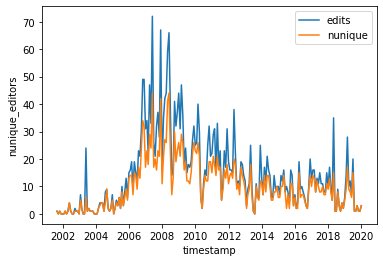

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

print( np.mean(df['edits'] / df['nunique_editors']) )
sns.lineplot(x='timestamp', y='edits', data=aardvark, label='edits')
sns.lineplot(x='timestamp', y='nunique_editors', data=aardvark, label='nunique')

In [47]:
print(-100  -99)
print(100  -99)
print(-100 ^ 99)
print(100 ^ 99)


-99
1
-1
7


In [48]:
def editor_engagement_score(df, outdir="./data/out"):
    diff_edits = [df['edits'][x] - df['edits'][x-1] for x in range(1, len(df))]
    diff_edits.insert(0,0)
    df['diff_edits'] = diff_edits
    diff_nunique = [df['nunique_editors'][x] - df['nunique_editors'][x-1] for x in range(1, len(df))]
    diff_nunique.insert(0, 0)
    df['diff_nunique'] = diff_nunique
    df['product'] = df['diff_edits'] * df['diff_nunique']
    df.to_csv(outdir + "/engagement_scores.csv', index=False)

    return df[['timestamp', 'diff_edits', 'diff_nunique', 'product']]

SyntaxError: EOL while scanning string literal (<ipython-input-48-61b8626ca68b>, line 9)

In [44]:
league_df = editor_engagement_score(league, '../data/out')
ax = sns.lineplot(x='timestamp', y='product', data=league_df)
ax.set_title("League Editor Engagement Score")
plt.show()

TypeError: editor_engagement_score() takes 1 positional argument but 2 were given

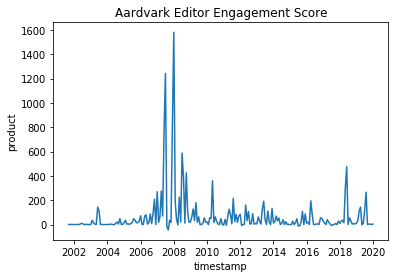

In [39]:
aardvark_df = editor_engagement_score(aardvark)
ax = sns.lineplot(x='timestamp', y='product', data=aardvark_df)
ax.set_title("Aardvark Editor Engagement Score")
plt.show()

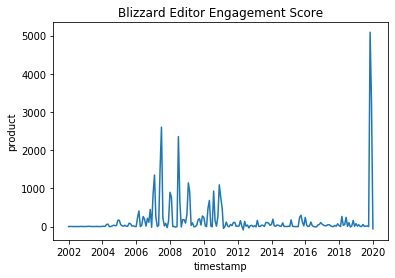

In [38]:
blizzard_df = editor_engagement_score(blizzard)
ax = sns.lineplot(x='timestamp', y='product', data=blizzard_df)
ax.set_title("Blizzard Editor Engagement Score")
plt.show()